# Engineer Training Data

Now that we have enriched the artist data with descriptive information about each artist, our next step is to join and refine the input data so that it can be used to train an AutoML classification model. 


In [1]:
import pandas as pd

In [2]:
play_counts_df = pd.read_feather("input_data/play_counts_df.feather")

In [3]:
play_counts_df.head()

,user_name,artist_name,cnt
0,munhoz,U2,31
1,pblsnchz,Black Sabbath,47
2,gbcox,U2,5856
3,tomcpc,U2,901
4,jerry_c,U2,584


Pivot the table, using the user_name as the index. This groups the data by user_name and retrieves a count per user of the number of listens for each artist.

In [4]:
play_counts_pivot_df = pd.DataFrame(play_counts_df.pivot(index='user_name', columns='artist_name', values='cnt').to_records())
play_counts_pivot_df.head()

,user_name,30 Seconds to Mars,65daysofstatic,A Perfect Circle,A Tribe Called Quest,ABBA,AC/DC,Adele,Aerosmith,Air,...,ZZ Top,alt-J,blink-182,deadmau5,久石譲,川井憲次,梶浦由記,植松伸夫,菅野よう子,近藤浩治
0,-andor-,<NA>,46,<NA>,43,7,13,<NA>,4,71,...,12,<NA>,<NA>,29,<NA>,1,<NA>,<NA>,<NA>,<NA>
1,-dAtA-TRoN-,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
2,-nils-,<NA>,2,49,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,...,8,<NA>,<NA>,<NA>,<NA>,12,<NA>,<NA>,<NA>,<NA>
3,00dani,<NA>,1,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,...,<NA>,3,<NA>,<NA>,<NA>,<NA>,<NA>,8,<NA>,10
4,00void,3,425,1,<NA>,<NA>,1,<NA>,12,17,...,6,<NA>,11,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>


In [5]:
# Double check that this value is 20
play_counts_pivot_df[play_counts_pivot_df.user_name == "-nils-"].iloc[0]['Muse']

20

In addition to the artist data for each user, we would also like to use information about the user's preferences for certain genres or styles of artist. To obtain features that represent this information, we're going to use the enriched artist data that was generated using the [1-Enrich_Raw_Input_Data.ipynb](./1-Enrich_Raw_Input_Data.ipynb) file.

Our goal here is to create a count for each user of the total number of times a particular LastFM tag is represented in that user's listening history. To do this, we'll join the user data with the tag data using 'artist' as the join key, then sum the tag columns to get a count for the total number of times a particular tag shows up in a user's listening history.

In [6]:
band_tags = pd.read_feather("enriched_data/band_tags.feather")
band_tags.head()

,artist_name,tag_alternative,tag_alternative rock,tag_rock,tag_indie,tag_electronic,tag_classic rock,tag_british,tag_60s,tag_pop,...,tag_jay z,tag_shoegazer,tag_hair metal,tag_rapcore,tag_underground hip hop,tag_symphonic black metal,tag_darkwave,tag_world,tag_latin,tag_spanish
0,Radiohead,True,True,True,True,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,The Beatles,False,False,True,False,False,True,True,True,True,...,False,False,False,False,False,False,False,False,False,False
2,Pink Floyd,False,False,True,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,Daft Punk,False,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,Muse,True,True,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [7]:
list(band_tags.columns)[:15]

['artist_name',
 'tag_alternative',
 'tag_alternative rock',
 'tag_rock',
 'tag_indie',
 'tag_electronic',
 'tag_classic rock',
 'tag_british',
 'tag_60s',
 'tag_pop',
 'tag_progressive rock',
 'tag_psychedelic rock',
 'tag_psychedelic',
 'tag_house',
 'tag_dance']

In [8]:
play_counts_with_tags_df = pd.merge(play_counts_df, band_tags, on='artist_name', how='left')
# prevent data leakage by removing Beatles data from the tag df
play_counts_with_tags_df_no_beatles = play_counts_with_tags_df[play_counts_with_tags_df['artist_name']!='The Beatles'].copy()
user_tag_counts_df = play_counts_with_tags_df_no_beatles.drop(columns=['artist_name','cnt']).groupby('user_name').sum().reset_index()
user_artist_tag_counts_df = pd.merge(play_counts_pivot_df, user_tag_counts_df, on='user_name', how='left')

In [9]:
user_artist_tag_counts_df.head()

,user_name,30 Seconds to Mars,65daysofstatic,A Perfect Circle,A Tribe Called Quest,ABBA,AC/DC,Adele,Aerosmith,Air,...,tag_jay z,tag_shoegazer,tag_hair metal,tag_rapcore,tag_underground hip hop,tag_symphonic black metal,tag_darkwave,tag_world,tag_latin,tag_spanish
0,-andor-,<NA>,46,<NA>,43,7,13,<NA>,4,71,...,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0
1,-dAtA-TRoN-,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-nils-,<NA>,2,49,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,...,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
3,00dani,<NA>,1,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,00void,3,425,1,<NA>,<NA>,1,<NA>,12,17,...,0.0,1.0,2.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0


Set a Target column to turn this into a classification problem, if they play Beatles (even once) then label is True. Then drop the column 'The Beatles' in order to prevent data leakage.

In [10]:
import numpy as np
user_artist_tag_counts_df['Like The Beatles'] =  user_artist_tag_counts_df['The Beatles'].notnull()
user_artist_tag_counts_df.drop('The Beatles', axis=1, inplace=True)

We need to clean up the column names as Cloud AutoML is very picky and will fail if you do things like have Unicode file names. I wish Google will fix this. I'll complain ;)

In [11]:
user_artist_tag_counts_df.columns = user_artist_tag_counts_df.columns.str.replace("post-roc", "post roc1", regex=False)
user_artist_tag_counts_df.columns = user_artist_tag_counts_df.columns.str.replace("trip-hop", "trip hop1", regex=False)
user_artist_tag_counts_df.columns = user_artist_tag_counts_df.columns.str.replace(" ", "_", regex=False)
user_artist_tag_counts_df.columns = user_artist_tag_counts_df.columns.str.replace("/", "", regex=False)
user_artist_tag_counts_df.columns = user_artist_tag_counts_df.columns.str.replace("é", "", regex=False)
user_artist_tag_counts_df.columns = user_artist_tag_counts_df.columns.str.replace("ö", "o", regex=False)
user_artist_tag_counts_df.columns = user_artist_tag_counts_df.columns.str.replace("+", "_and_", regex=False)
user_artist_tag_counts_df.columns = user_artist_tag_counts_df.columns.str.replace("&", "and", regex=False)
user_artist_tag_counts_df.columns = user_artist_tag_counts_df.columns.str.replace("!", "", regex=False)
user_artist_tag_counts_df.columns = user_artist_tag_counts_df.columns.str.replace("-", "_", regex=False)
user_artist_tag_counts_df.columns = user_artist_tag_counts_df.columns.str.replace(".", "", regex=False)
user_artist_tag_counts_df.columns = user_artist_tag_counts_df.columns.str.replace("ó", "o", regex=False)
user_artist_tag_counts_df.columns = user_artist_tag_counts_df.columns.str.replace("'", "", regex=False)

# Japanese Artists
user_artist_tag_counts_df.columns = user_artist_tag_counts_df.columns.str.replace("久石譲", "Joe_Hisaishi", regex=False)
user_artist_tag_counts_df.columns = user_artist_tag_counts_df.columns.str.replace("川井憲次", "Kenji_Kawai", regex=False)
user_artist_tag_counts_df.columns = user_artist_tag_counts_df.columns.str.replace("梶浦由記", "Yuki_Kajiura", regex=False)
user_artist_tag_counts_df.columns = user_artist_tag_counts_df.columns.str.replace("植松伸夫", "Nobuo_Uematsu", regex=False)
user_artist_tag_counts_df.columns = user_artist_tag_counts_df.columns.str.replace("菅野よう子", "Yoko_Kanno", regex=False)
user_artist_tag_counts_df.columns = user_artist_tag_counts_df.columns.str.replace("近藤浩治", "Koji_Kondo", regex=False)

Let's set aside a random sample of data as a holdout set in order to test the trained and deployed model.

In [12]:
user_artist_tag_counts_df.shape

(2495, 514)

<AxesSubplot:ylabel='Like_The_Beatles'>

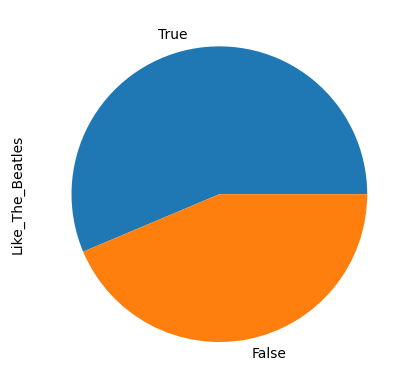

In [13]:
user_artist_tag_counts_df.Like_The_Beatles.value_counts().plot(kind='pie')

In [14]:
user_artist_tag_counts_df.shape

(2495, 514)

In [15]:
# pull 10 data points to test online model serving

In [16]:
inference_sample = user_artist_tag_counts_df.sample(n=10, random_state=42)
inference_sample.reset_index(drop=True).to_feather("test_data/inference_sample.feather")

In [17]:
remainder = user_artist_tag_counts_df.drop(inference_sample.index)
train_sample = remainder.sample(n=1985, random_state=42)
remainder = remainder.drop(train_sample.index)
validation_sample = remainder.sample(n=250, random_state=42)
test_sample = remainder.drop(validation_sample.index)

In [18]:
train_sample.loc[:, "data_split"] = "TRAIN"
validation_sample.loc[:, "data_split"] = "VALIDATE"
test_sample.loc[:, "data_split"] = "TEST"

In [19]:
# Confirm that these numbers add up the way they should
train_sample.shape[0] + validation_sample.shape[0] + test_sample.shape[0] + inference_sample.shape[0] == user_artist_tag_counts_df.shape[0]

True

In [20]:
input_data_df = pd.concat([train_sample, validation_sample, test_sample])

In [21]:
input_data_df.shape

(2485, 515)

In [22]:
input_data_df.to_csv("training_data/file_out_2485_tags.csv", index=None, encoding="utf-8")

Running head on the output CSV file will serve as a quick gut check to make sure that everything looks good in the CSV file.

In [23]:
input_data_df.data_split.value_counts()

TRAIN       1985
VALIDATE     250
TEST         250
Name: data_split, dtype: int64

In [24]:
input_data_df.data_split.value_counts() / len(input_data_df)

TRAIN       0.798793
VALIDATE    0.100604
TEST        0.100604
Name: data_split, dtype: float64

In [25]:
!head training_data/file_out_2485_tags.csv

user_name,30_Seconds_to_Mars,65daysofstatic,A_Perfect_Circle,A_Tribe_Called_Quest,ABBA,ACDC,Adele,Aerosmith,Air,Alanis_Morissette,Alice_in_Chains,Amon_Amarth,Amon_Tobin,Amorphis,Anal_Cunt,Anathema,Animal_Collective,Aphex_Twin,Apocalyptica,Arcade_Fire,Arctic_Monkeys,Audioslave,Autechre,Avenged_Sevenfold,Avril_Lavigne,Ayreon,Bad_Religion,Beach_House,Beastie_Boys,Beck,Belle_and_Sebastian,Beyonc,Bjork,Black_Sabbath,Blind_Guardian,Bloc_Party,Blur,Boards_of_Canada,Bob_Dylan,Bob_Marley_and_The_Wailers,Bon_Iver,Bon_Jovi,Bonobo,Brand_New,Breaking_Benjamin,Brian_Eno,Britney_Spears,Broken_Social_Scene,Bruce_Springsteen,Burial,Bush,CHVRCHES,Cake,Calvin_Harris,Carly_Rae_Jepsen,Childish_Gambino,Children_of_Bodom,Cocteau_Twins,Coheed_and_Cambria,Coldplay,Cradle_of_Filth,Creedence_Clearwater_Revival,Crystal_Castles,DJ_Shadow,Daft_Punk,Dark_Tranquillity,Dave_Matthews_Band,David_Bowie,Dead_Can_Dance,Death_Cab_for_Cutie,Death_Grips,Deep_Purple,Deftones,Depeche_Mode,Dire_Straits,Disturbed,Drake,Dream_Thea

The line below copies the CSV file that was just output to a GCS bucket in Google Cloud.

In [26]:
!gsutil cp training_data/file_out_2485_tags.csv gs://csalling-docai-datasets-regional/beatles/file_out_2485_tags.csv

Copying file://training_data/file_out_2485_tags.csv [Content-Type=text/csv]...
/ [1 files][  3.2 MiB/  3.2 MiB]                                                
Operation completed over 1 objects/3.2 MiB.                                      


Note that normally I wouldn't use a bucket obviously intended for a different application, but right now for some reason we can only create buckets that are in Finland, so I'm using an older bucket I had lying around for experimentation purposes.